In [1]:
import numpy as np
import networkx as nx

In [12]:
TIME_HORIZON = 1400 # minutes
EV_ENERGY_CONSUMPTION_RATE = 0.16 # kW/km
EV_MAX_BATTERY_CAPACITY = 54.75 # kWh
EVCS_CHARGING_EFFICIENCY = 0.9 # kW
CHARGING_POWER = 60 # kW
SEED = 42
np.random.seed(SEED)

In [3]:
uniform_arrivals = np.sort(np.random.uniform(360,1200,80).astype(int))

In [4]:
uniform_arrivals

array([ 364,  377,  388,  397,  399,  408,  414,  422,  422,  434,  442,
        457,  462,  477,  478,  491,  491,  503,  512,  514,  515,  524,
        526,  527,  538,  577,  587,  595,  604,  605,  615,  615,  621,
        633,  659,  661,  667,  674,  686,  722,  729,  743,  775,  791,
        796,  800,  815,  819,  857,  862,  862,  864,  870,  873,  916,
        934,  953,  954,  972,  974, 1007, 1008, 1011, 1019, 1033, 1039,
       1044, 1056, 1059, 1087, 1111, 1123, 1134, 1149, 1157, 1158, 1171,
       1174, 1174, 1188])

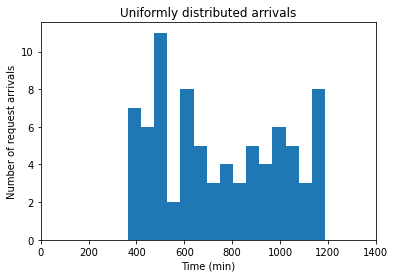

In [5]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(uniform_arrivals, 15, density=False)
plt.xlim([0, 1400])
plt.title("Uniformly distributed arrivals")
plt.ylabel("Number of request arrivals")
plt.xlabel("Time (min)")
plt.show()

## Simulate one episode

In [6]:
from modules.traffic_preprocess import TrafficPreprocessModule
from entities.evcs import ChargingStation
from entities.charging_request import ChargingRequest
from topologies.graph import Graph


In [7]:
def generate_random_node_pair(nodes_list):
    node_pair = []
    while len(node_pair) < 2:
        node_pair = np.random.choice(nodes_list, 2, replace=False)
    return node_pair

def load_topology(topology_dir):
    file = open(topology_dir, "rb")
    G = nx.read_edgelist(file)
    file.close()
    print(
        f'🏙️  Loaded topology with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.')
    return G

In [11]:
last_request_time = 0

G = load_topology("topologies/santiago.edgelist")
G_utils = Graph(G)

TPM = TrafficPreprocessModule(G)
traffic_network = TPM.get_traffic_network()
nodes_labels = G_utils.get_nodes_labels(exclude_evcs=True)
evcs_labels = G_utils.get_evcs_labels()
charging_stations = [ChargingStation(label, 0.5) for label in evcs_labels]
charging_requests = []
for t in range(TIME_HORIZON):
    if t in uniform_arrivals:
        # Generate a new request and add it to the queue
        node_pair = generate_random_node_pair(nodes_labels)
        delta_t = t - last_request_time
        initial_soc = np.random.uniform(0.2, 0.4)
        required_soc = 0.9
        last_request_time = t
        charging_requests.append(ChargingRequest(
            node_pair[0], node_pair[1], t, delta_t, initial_soc, required_soc))

        evcs_arrival_times = [t + TPM.get_total_time(
            node_pair[0], evcs_label) for evcs_label in evcs_labels]

        # array that contains total energy consumption from source node to each EVCS
        evcs_total_energy_consumption = EV_ENERGY_CONSUMPTION_RATE * \
            np.array([G_utils.get_total_distance(node_pair[0], evcs_label)
                     for evcs_label in evcs_labels])
        evcs_soc_arrival = initial_soc - \
            evcs_total_energy_consumption/EV_MAX_BATTERY_CAPACITY
        evcs_charging_energy_required = (
            required_soc - evcs_soc_arrival)*EV_MAX_BATTERY_CAPACITY
        evcs_charging_time_required = evcs_charging_energy_required / \
            (EVCS_CHARGING_EFFICIENCY*CHARGING_POWER)
        evcs_driving_times = np.array([TPM.get_total_time(
            node_pair[0], evcs_label) + TPM.get_total_time(evcs_label, node_pair[1]) for evcs_label in evcs_labels])
        evcs_total_driving_distance = np.array([G_utils.get_total_distance(
            node_pair[0], evcs_label) for evcs_label in evcs_labels])

        print("Arrival at {}, delta_t: {}, node pair: {}".format(
            t, delta_t, node_pair))
        print("Arrival times: {}".format(evcs_arrival_times))


🏙️  Loaded topology with 33 nodes and 49 edges.
Arrival at 364, delta_t: 364, node pair: ['9' '14']
Arrival times: [375.85, 375.45, 371.522, 378.082, 382.06, 380.414, 379.436, 378.43]
Arrival at 377, delta_t: 13, node pair: ['19' '14']
Arrival times: [402.65, 397.913, 385.242, 400.006, 382.47, 379.723, 377.756, 381.707]
Arrival at 388, delta_t: 11, node pair: ['7' '1']
Arrival times: [394.75, 398.68, 400.622, 402.375, 411.16, 409.514, 408.536, 407.53]
Arrival at 397, delta_t: 9, node pair: ['4' '3']
Arrival times: [421.69, 412.159, 407.08, 408.464, 404.48, 412.673, 410.706, 414.657]
Arrival at 399, delta_t: 2, node pair: ['7' '25']
Arrival times: [405.75, 409.68, 411.622, 413.375, 422.16, 420.514, 419.536, 418.53]
Arrival at 408, delta_t: 9, node pair: ['5' '13']
Arrival times: [433.79, 429.053, 416.382, 430.184, 411.24, 412.953, 410.986, 414.937]
Arrival at 414, delta_t: 6, node pair: ['18' '26']
Arrival times: [441.516, 436.779, 424.108, 438.872, 421.336, 414.857, 415.11, 416.841]
Ar

In [9]:
range(TIME_HORIZON)[-1]

1399

In [14]:
print(traffic_network)

Graph with 33 nodes and 49 edges


## Environment implementation

In [13]:
import gym
from gym import spaces
import numpy as np

In [14]:
G = load_topology("topologies/santiago.edgelist")

🏙️  Loaded topology with 33 nodes and 49 edges.


In [15]:
class RouteChargingStationEnv(gym.Env):
    def __init__(self, G):
        self.G = G
        self.G_utils = Graph(G)
        self.TPM = TrafficPreprocessModule(G)
        self.traffic_network = self.TPM.get_traffic_network()
        self.nodes_labels = self.G_utils.get_nodes_labels(exclude_evcs=True)
        self.evcs_labels = self.G_utils.get_evcs_labels()
        self.charging_stations = [ChargingStation(label, 0.5) for label in self.evcs_labels]
        self.charging_requests = []
        self.last_request_time = 0
        # 1D observation space with size 6+4*len(evcs_labels)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(6+4*len(self.evcs_labels),), dtype=np.float32)


In [36]:
spaces.Box(low=-np.inf, high=np.inf, shape=(1,4), dtype=np.float32)

Box([[-inf -inf -inf -inf]], [[inf inf inf inf]], (1, 4), float32)